# Homework 02

In [93]:
import pandas as pd
import numpy as np
import re
import random
import os
import shutil
# !pip install tensorflow_datasets
# ! pip install tensorflow --upgrade
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import models, layers, preprocessing, optimizers, losses, metrics
tfds.disable_progress_bar()
import nltk
from nltk.corpus import stopwords
import keras.layers
from keras import backend as K

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

## Task 1

In [3]:
# Dataset can be download from the website https://strubell.github.io/teaching/11-830/assignments/files/civility_data.tar.gz

dev_df=pd.read_csv("civility_data/dev.tsv",sep="\t",header=0)
mini_demodev_df=pd.read_csv("civility_data/mini_demographic_dev.tsv",sep="\t",header=0)

In [4]:
mini_demodev_df=mini_demodev_df.fillna(0)

In [5]:
dev_df.loc[dev_df.perspective_score>0.8,"label_ps"]='OFF'
dev_df.loc[dev_df.perspective_score<=0.8,"label_ps"]='NOT'

In [6]:
mini_demodev_df.loc[mini_demodev_df.perspective_score>0.8,"label_ps"]='OFF'
mini_demodev_df.loc[mini_demodev_df.perspective_score<=0.8,"label_ps"]="NOT"

In [7]:
class Matrics:
    def __init__(self,targets,gold):
        self.tp=0
        self.tn=0
        self.fp=0
        self.fn=0
        self.targetsize=len(targets)
        for i in range(len(targets)):
            if targets[i] ==1. and gold[i] ==1.: # classify offensive claim as OFF
                self.tp+=1
            elif targets[i] == 0. and gold[i] == 0.: # classify non-offensive claim as NOT
                self.tn+=1
            elif targets[i] == 0. and gold[i] ==1.: # classify offensive claim as NOT
                self.fp+=1
            elif targets[i] == 1. and gold[i]== 0.: # classify non-offensive claim as OFF
                self.fn+=1

    def f1_score(self):
        p=self.precision()
        r=self.recall()
        return 2*((p*r)/(p+r))

    def precision(self):
        tp=self.tp
        fp=self.fp
        return tp/(tp+fp)

    def recall(self):
        tp = self.tp
        fn = self.fn
        return tp/(tp+fn)

    def accuracy(self,targets,gold):
        right=0
        for x,y in zip(targets,gold):
            if x==y:
                right+=1
        return right/len(targets)

    def PFR_score(self):
        return self.fn/self.targetsize

    def summary(self,targets,golds):
        print("The accuracy is {0}".format(self.accuracy(targets,golds)))
        print("The F1_score is {0}".format(self.f1_score()))

def normalize_label(labels):
    '''
    encode label to 0,1. 'OFF' to 1, 'NOT' to 0
    '''
    labels_encoded=[]
    for label in labels:
        if label=='OFF':
            labels_encoded.append(1)
        elif label=='NOT':
            labels_encoded.append(0)
    if len(labels_encoded)!=len(labels):
        raise ValueError
    else:
        return labels_encoded


In [8]:
print('-'*30+'1.1.b Starting '+'-'*30)
dev_y=dev_df.label.tolist()
dev_X=dev_df.label_ps.tolist()
dev_y=normalize_label(dev_y)
dev_X=normalize_label(dev_X)
m=Matrics(dev_X,dev_y)
m.summary(dev_X,dev_y)
print('-'*30+'1.1.b Ending '+'-'*30)

------------------------------1.1.b Starting ------------------------------
The accuracy is 0.7643504531722054
The F1_score is 0.4851485148514852
------------------------------1.1.b Ending ------------------------------


In [9]:
print('-'*30+'1.1.c Starting '+'-'*30)
mini_demodev_X=mini_demodev_df.label_ps.tolist()
mini_demodev_X=normalize_label(mini_demodev_X)
mini_demodev_y=np.zeros(len(mini_demodev_X)).tolist()
m=Matrics(mini_demodev_X,mini_demodev_y)
print("The False Positive Rate is {0}".format(m.PFR_score()))
print('-'*30+'1.1.c Ending '+'-'*30)

------------------------------1.1.c Starting ------------------------------
The False Positive Rate is 0.08063880126182965
------------------------------1.1.c Ending ------------------------------


In [10]:
print('='*30+'1.2 Custom Classifier Starting '+'='*30)

==============================1.2 Custom Classifier Starting ==============================


In [100]:
random.seed(42)
tf.random.set_seed(42)

def normalize_label(labels):
    '''
    encode label to 0,1. 'OFF' to 1, 'NOT' to 0
    '''
    labels_encoded=[]
    for label in labels:
        if label=='OFF':
            labels_encoded.append((0,1))
        elif label=='NOT':
            labels_encoded.append((1,0))
    if len(labels_encoded)!=len(labels):
        raise ValueError
    else:
        return labels_encoded


def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('label')
  labels=np.array(normalize_label(labels))
  ds = tf.data.Dataset.from_tensor_slices((dataframe.text.values,labels)) #create a dataset is to create it from a list
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size) #Combines consecutive elements of this dataset into batches
  ds = ds.prefetch(batch_size) # Creates a Dataset that prefetches (pre-processing) elements from this dataset.
  return ds



def read_data(filepath,batch_size=50):
    df = pd.read_csv(filepath,sep='\t',header=0)
    batch_size=batch_size
    df.text=df.text.apply(lambda x : preprocessing(x))

    train_ds = df_to_dataset(df, batch_size=batch_size)

    return train_ds

def preprocessing(sentence):
    # remove @User
    # result=' '.join(re.sub("(@[A-Za-z0-9]+)"," ",sentence).split())
    restr=r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    text_noURL=re.sub(restr," ", sentence)
    text_noHashTag=re.sub("#"," ", text_noURL)
    text_noHashTag=re.sub("(@[A-Za-z0-9]+)"," ",text_noHashTag)
    text_noPunc=re.sub("[^a-zA-Z#]"," ", text_noHashTag)
    words=[word for word in text_noPunc.lower().split() if word not in stopwords.words("english")]
    result=' '.join(words)

    # remove punctuation



    return result

# tmp='Yes you are but I was asking what is it @User about the movie ?🤷‍♂️👀	'
# preprocessing(tmp)
# train=read_data("civility_data/train.tsv")
# dev=read_data("civility_data/dev.tsv")


In [66]:
for example, label in train.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  [b'gun control keep terrorists shooting'
 b'look date tweet telling sure maga url'
 b'ford knew moment came forward anonymously name would get effort stall kavanaugh nomination yo accusations knowingly proven throw mud last minute resistance looks like'
 b'needs placed naked stocks stockholm swedish people sik heil backside'
 b'hillary clinton potus oops'
 b'president trump order declassify fisa docs text messages proves keeping campaign promise working draintheswamp breaking fisadocs declassified deepstatecorruption politics maga'
 b'amen ready' b'like holy jesus fucken christ'
 b'zac goldsmith faux conservative party use faux conservative party use khan defence organiser conservatives f cking useless ask deliberate share labour agenda useless'
 b'following anyway' b'christian' b'pope say sinner yet unveiled'
 b'gun control' b'go figure' b'want societal dregs take look antifa'
 b'lib registered democrat thats need know'
 b'republicans love say early talk common sense gun contro

In [59]:
rep=[word for item in text for word in item.split()]

In [62]:
print(len(set(rep)))

16356


In [72]:
VOCAB_SIZE = 10000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train.map(lambda text, label: text))

In [73]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[   4,    5,   55,  613,  386,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [  61, 1498,  254,  385,   73,    8,    2,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [ 320,  425,  694,  677,  429,    1,  179,   16,   13, 3273, 3021,
          53, 1456, 1161,  836, 4762,  524,  799, 3132,  170, 1187,  849,
         181,    7,    0,    0,    0,    0,    0,    0]], dtype=int64)

In [74]:
len(encoder.get_vocabulary())

10000

111/265 [===========>..................] - ETA: 41s - loss: 0.5157 - accuracy: 0.7939 - f1_m: 0.6500 - precision_m: 0.8457 - recall_m: 0.5322

------------------------------Starting reading data and preprocessing------------------------------
------------------------------End preprocessing------------------------------
------------------------------Starting training model------------------------------
Epoch 1/3
265/265 [==============================] - 85s 261ms/step - loss: 0.6688 - accuracy: 0.6645 - f1_m: 0.1522 - precision_m: 0.3527 - recall_m: 0.1023 - val_loss: 0.6460 - val_accuracy: 0.6677 - val_f1_m: 0.4711 - val_precision_m: 0.6765 - val_recall_m: 0.3662
Epoch 2/3
265/265 [==============================] - 76s 287ms/step - loss: 0.6173 - accuracy: 0.6803 - f1_m: 0.5103 - precision_m: 0.7356 - recall_m: 0.3945 - val_loss: 0.6020 - val_accuracy: 0.7047 - val_f1_m: 0.5396 - val_precision_m: 0.7711 - val_recall_m: 0.4169
Epoch 3/3
265/265 [==============================] - 76s 289ms/step - loss: 0.4929 - accuracy: 0.8003 - f1_m: 0.6965 - precision_m: 0.8475 - recall_m: 0.5969 - val_loss: 0.5706 - val_accuracy: 0.7409 - 

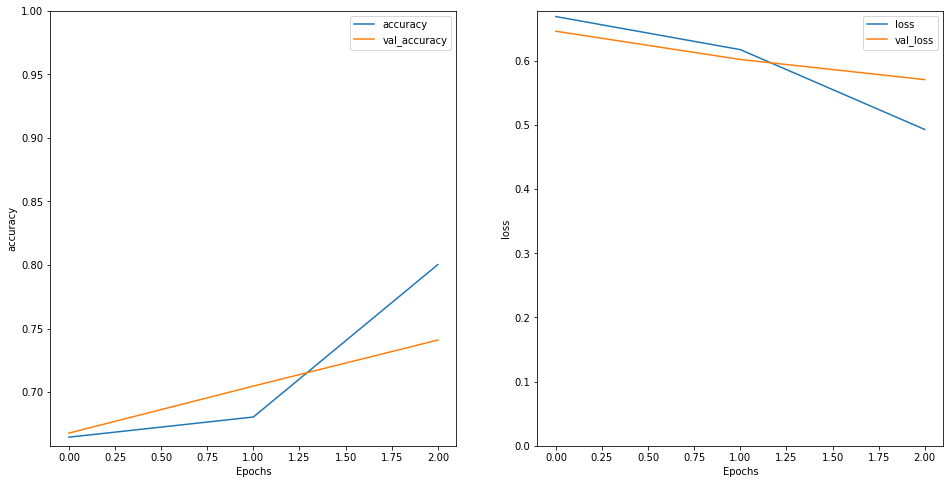

In [106]:
class RNNClassifier:
    def __init__(self,modelsavepath='model/my_model.cpdk', modelloadpath='model/my_model.cpdk'):
        self.model=self.build_model()
        self.MODELSAVEPATH=modelsavepath
        self.MODELSAVEPATH=modelloadpath

    def build_model(self):
        model = tf.keras.Sequential([
            encoder,
            tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(2)
        ])


        def recall_m(y_true, y_pred):
            true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
            possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
            recall = true_positives / (possible_positives + K.epsilon())
            return recall

        def precision_m(y_true, y_pred):
            true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
            predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
            precision = true_positives / (predicted_positives + K.epsilon())
            return precision

        def f1_m(y_true, y_pred):
            precision = precision_m(y_true, y_pred)
            recall = recall_m(y_true, y_pred)
            return 2*((precision*recall)/(precision+recall+K.epsilon()))


        model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                      optimizer=tf.keras.optimizers.Adam(1e-4),
                      metrics=['accuracy',f1_m,precision_m, recall_m])

        return model

    def train(self,train,dev,epochs=40):
        callback_list=[
            keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=2,
                mode="max"
            ),
            keras.callbacks.ModelCheckpoint(
                filepath=self.MODELSAVEPATH,
                monitor='val_loss',
                save_weights_only=True,
                save_best_only=True,
            )
        ]
        model=self.model
        history = model.fit(train, epochs=epochs,validation_data=dev,callbacks=callback_list)
        model.save_weights(self.MODELSAVEPATH)
        self.loss_figure(history)
        self.model=model

    def load_weights(self):
        self.model=self.load_weights(self.MODELSAVEPATH)

    def loss_figure(self,history):
        plt.figure(figsize=(16, 8))
        plt.subplot(1, 2, 1)
        self.plot_graphs(history, 'accuracy')
        plt.ylim(None, 1)
        plt.subplot(1, 2, 2)
        self.plot_graphs(history, 'loss')
        plt.ylim(0, None)

    def plot_graphs(self,history, metric):
      plt.plot(history.history[metric])
      plt.plot(history.history['val_'+metric], '')
      plt.xlabel("Epochs")
      plt.ylabel(metric)
      plt.legend([metric, 'val_'+metric])




print("-"*30+"Starting reading data and preprocessing"+"-"*30)
train=read_data("civility_data/train.tsv",batch_size=40)
dev=read_data("civility_data/dev.tsv",batch_size=40)
print("-"*30+"End preprocessing"+"-"*30)

print("-"*30+"Starting training model"+"-"*30)
classifier=RNNClassifier()
classifier.train(train,dev)
print("-"*30+"End training model"+"-"*30)



In [109]:
loss, acc, f1_m, precision_m, recall_m=classifier.model.evaluate(dev)
print("The accruracy is {0}, the f1-score is {1}".format(acc,f1_m))

34/34 [==============================] - 3s 91ms/step - loss: 0.5706 - accuracy: 0.7409 - f1_m: 0.6602 - precision_m: 0.7572 - recall_m: 0.5875
The accruracy is 0.7409365773200989, the f1-score is 0.6602420210838318


In [108]:
def predict_class(model,test):
    results=[]
    matrix=model.predict(test)
    for item in matrix:
        results.append(np.argmax(item))
    return results

def devectorize_label(vec_labels):
    results=[]
    for item in vec_labels:
        for label in item:
            results.append(np.argmax(label))
    return results

predictions=predict_class(classifier.model,dev.map(lambda text, label: text))
gold_dev_labels=devectorize_label(dev.map(lambda text, label: label))
m=Matrics(predictions,gold_dev_labels)
m.summary(predictions,gold_dev_labels)

34/34 [==============================] - 8s 79ms/step
The accuracy is 0.5702416918429003
The F1_score is 0.28247162673392184


In [ ]:
print(gold_dev_labels)


In [88]:
from sklearn.metrics import classification_report
print(classification_report(gold_dev_labels, predictions))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67       884
           1       0.33      0.33      0.33       440

    accuracy                           0.56      1324
   macro avg       0.50      0.50      0.50      1324
weighted avg       0.56      0.56      0.56      1324



In [ ]:


# should OFF (0,1)
print(model.predict(['People died in PR because the local government is corrupt.']))

# should NOT (1,0)
print(model.predict(['Dont forget my girl Hillary she is doing the happy dance tonight']))

# should OFF (0,1)
print(model.predict(['Oh noes! Tough shit']))

#should NOT(1,0)
print(model.predict([' you are also the king of taste']))

In [ ]:
test_loss, test_acc = model.evaluate(dev)

In [ ]:
model.predict(dev.map(lambda text, label: text))

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

In [ ]:
padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

In [89]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])

(0.0, 0.8237302616238594)

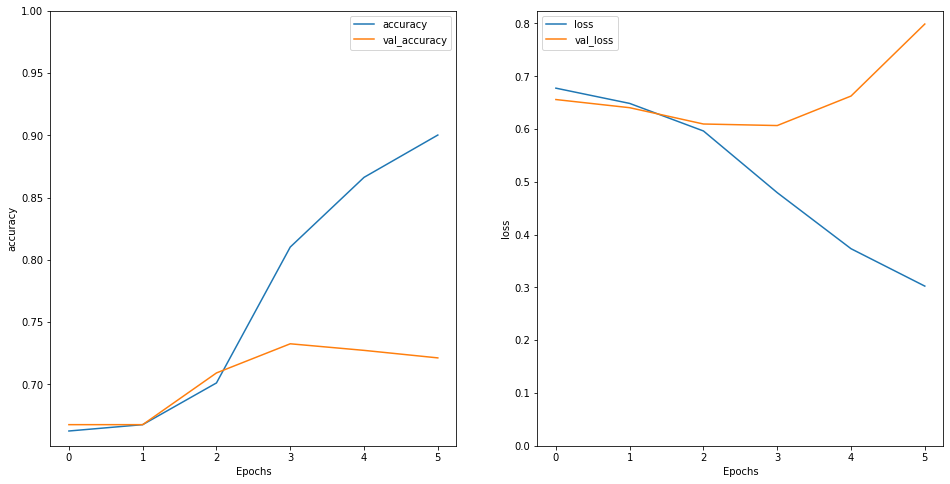

In [ ]:
def inspect_NaN(df):
    is_nan=df.isna()
    has_nan_row=is_nan.any(axis=1)
    print(df[has_nan_row])